<img src="./assets/Daraz-Symbol.png" alt="Logo" style="float:left;width:100px;"/>

# Daraz Knowledge graph

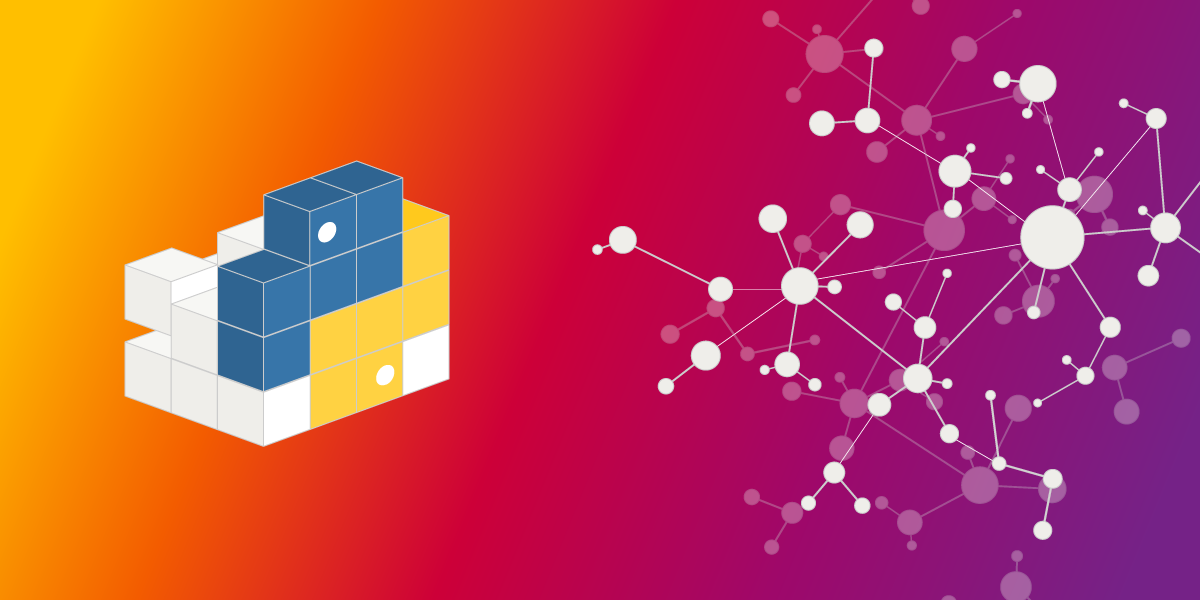

 knowledge graph is a type of database that represents knowledge as a network of interrelated concepts. It's a powerful tool for organizing and integrating large amounts of data from different sources, making it easier to search, query, and analyze.

In a knowledge graph, entities (such as people, places, or things) are represented as nodes, and relationships between entities are represented as edges. These nodes and edges can have attributes or properties that provide additional information about them.

Knowledge graphs are used in a variety of applications, including search engines, recommendation systems, and natural language processing.

# Introduction

We have already scraped daraz.com.np/smartphones, you can check out Daraz_scraper.ipynb file for that.
Now are are going to build a knowledge graph using 
- pandas (for structuring web scraped raw data)
- networkx (for transforming data into graph based representation)
- matplotlib (for visualizing the knowledge graph)

# Knowledge graph Schema 

A knowledge graph schema is a blueprint or framework that defines the structure, entities, relationships, and properties of a knowledge graph. It provides a formal representation of the domain-specific knowledge that the graph aims to capture, making it easier for users to understand, query, and analyze the data in the graph.


Let's build schema for the knowledge graph first. This will helps us to specify which information to be included while we prepare dataframe. 

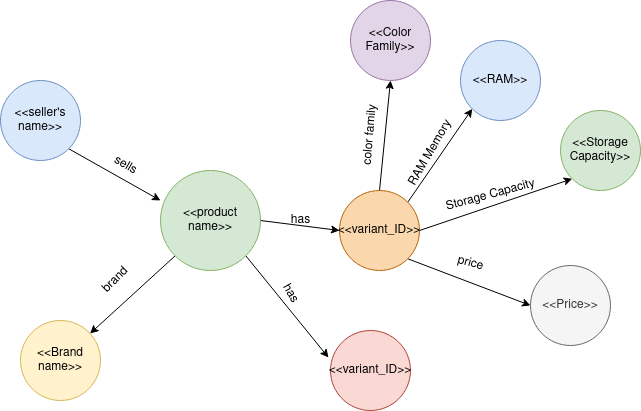

Note that, for simplicity, we haven't included any attributes to the nodes and to the edges. Variant_ID is a node that we are going to distinguish same product that has dynamic price range with respect to RAM and Storage Capacity. It means, same product can have different price and other specification associated with each variant_ID.

# Loading dataset

Let's load the dataset, since our data is in json format, we need to load it using json librabry.

In [1]:
import json
import pandas as pd

In [2]:
with open("../archives/daraz_scraped_data_v3.json", 'r') as f:
    raw_data = json.load(f)

In [3]:
len(raw_data)

880

In [4]:
raw_data[0]

{'name': 'realme 10 Pro Plus | 8GB RAM & 128GB ROM',
 'url': 'https://www.daraz.com.np/products/realme-10-pro-plus-8gb-ram-128gb-rom-i123076745-s1033443679.html?search=1',
 'rating': 0.0,
 'review': 0.0,
 'brand_name': 'RealMe',
 'brand_id': '202391',
 'seller_name': 'NS Traders Suppliers',
 'description': {'os': [['realme ui 4.0', 'based on android 13']],
  'rear camera': [['108mp prolight camera + 8mp ultra-wide angle camera +  2mp macro camera']]},
 'details': {'Brand': 'RealMe',
  'SKU': '123076745_NP-1033443679',
  'Battery Capacity': '4000 - 4999 mAh',
  'Screen Size (inches)': '6.6 - 7 Inch',
  'Build Type': 'Not Specified',
  'Camera Front (Megapixels)': '16MP',
  'Camera Back (Megapixels)': '108MP+8MP+2MP',
  'Number Of Cameras': '4',
  'Display Protection': 'Glass',
  'Model Year': '2022',
  'Network Connections': '4G,3G,2G,5G',
  'Fast Charging': '67W Supervooc Charge',
  'Wireless Charging': 'No',
  'Number of SIM Slots': '2',
  'Charger Type': 'Type-C',
  'Flash': 'Yes',
 

# Preprocessing

There is not much preprocessing needed, since we have done some processing during scraping. But, as you can see we have Devanagari script in some fields. Thus, they needs to be transformed into English script.

In [5]:
raw_data[0]['details']['price_n_prop']

[{'price_info': {'discount': '-1%',
   'originalPrice': {'text': 'Rs. 45,999', 'value': 45999},
   'salePrice': {'text': 'Rs. 45,447', 'value': 45447}},
  'props': {'रंग परिवार': 'Hyperspace Gold',
   'र्याम मेमोरी': '8GB',
   'भण्डारण क्षमता': '128GB'}}]

In [6]:
raw_data[-1]['details']['price_n_prop']

[{'price_info': {'discount': '-1%',
   'originalPrice': {'text': 'Rs. 157,990', 'value': 157990},
   'salePrice': {'text': 'Rs. 156,410', 'value': 156410}},
  'props': {'Color Family': 'Black',
   'RAM Memory': '6GB',
   'Storage Capacity': '256GB'}}]

In [7]:
# defining mapper that map devanagari to english script
eng_to_np = {'Color Family': 'रंग परिवार', 
             'RAM Memory': 'र्याम मेमोरी',
             'Storage Capacity': 'भण्डारण क्षमता'}

Since, the "key" needs to be transformed into english script, it is quite complex to perform preprocessing separately. Instead of that, we can transform it while we are build dataframe.

# Transform JSON into DataFrame

JSON data is not well structured, to need to transform the JSON data into DataFrame, simultaneously we are going to perform some preprocessing if needed and keep only the interested data items into dataframe.

For the shake of simplicity, we are ignoring some attribute which we are probably going to include while building knowledge graph with neo4j. Thus, for now let's stick to the simplicity.

Interested columns : name, brand_name, seller_name, battery Capacity, Camera Front, Vriant_hash, Color_family, RAM memory, Storage Capacity, price.

In [8]:
from tqdm import tqdm
import re

In [9]:
df = pd.DataFrame(columns=['name', 'brand_name', 'seller_name', 'Battery Capacity', 
                           'Camera Front (Megapixels)', 'variant_hash',
                          'color_family', 'RAM Memory', 'Storage Capacity', 'price'
                          ])

In [10]:
def extract_product_name(raw_name):
    '''
        it will return the actual product name by clipping it from the raw_text
        
        args:
            raw_name: string
        returns:
            clipped_name: string
        
        example:
        >> raw_name = "realme 10 Pro Plus | 8GB RAM & 128GB ROM"
        >> extract_product_name(raw_name)
        "realme 10 Pro Plus"
        
    '''
    pattern  = "([\w\s]*)"
    matches = re.search(pattern, raw_name)
    clipped_name = matches.groups(1)[0].strip()
    if len(clipped_name) > 20:
        return clipped_name[:20]
    return clipped_name

In [11]:
# Transforme the JSON into dataframe
variant_ID = 0
for product_dict in tqdm(raw_data):
    name = extract_product_name(product_dict['name'])
    brand_name=product_dict['brand_name']
    seller_name = product_dict['seller_name']
    battery_capacity= product_dict['details'].get('Battery Capacity', '')
    camera_front= product_dict['details'].get('Camera Front (Megapixels)', '')
    
    for price_n_prop in product_dict['details'].get('price_n_prop', []):
        color_family = price_n_prop['props'].get('Color Family', '')
        ram = price_n_prop['props'].get('RAM Memory', '')
        storage = price_n_prop['props'].get('Storage Capacity', '')
        
        if color_family == '' and ram =='' and  storage == '':
            color_family = price_n_prop['props'].get(eng_to_np['Color Family'], '')
            ram = price_n_prop['props'].get(eng_to_np['RAM Memory'], '')
            storage = price_n_prop['props'].get(eng_to_np['Storage Capacity'], '')
            
#         hash_key = name + color_family + ram + storage
#         hash_object = hashlib.sha1(bytes(hash_key, 'utf-8'))
#         variant = hash_object.hexdigest() 
        price = price_n_prop['price_info']['salePrice']['text']
        
        variant_display_name = f'variant: {variant_ID}' 
        
        # append row
        series = pd.Series({'name': name,
                            'brand_name': brand_name,
                            'seller_name': seller_name,
                            'Battery Capacity': battery_capacity,
                            'Camera Front (Megapixels)': camera_front,
                            'variant_hash': variant_display_name,
                            'color_family': color_family,
                            'RAM Memory': ram,
                            'Storage Capacity': storage,
                            'price': price}) 
        df = df.append(series, ignore_index=True)
        variant_ID += 1
        

100%|████████████████████████████████████████| 880/880 [00:02<00:00, 350.59it/s]


In [12]:
df.head()

,name,brand_name,seller_name,Battery Capacity,Camera Front (Megapixels),variant_hash,color_family,RAM Memory,Storage Capacity,price
0,realme 10 Pro Plus,RealMe,NS Traders Suppliers,4000 - 4999 mAh,16MP,variant: 0,Hyperspace Gold,8GB,128GB,"Rs. 45,447"
1,Samsung Galaxy A53 5,Samsung,Electronics Planet,Not Specified,Not Specified,variant: 1,Multicolor,8GB,128GB,"Rs. 56,500"
2,Realme Narzo 50,narzo by realme,S&P Gadgets Hub,5000 - 5999 mAh,16MP,variant: 2,Blue,4GB,64GB,"Rs. 23,899"
3,Realme Narzo 50,narzo by realme,S&P Gadgets Hub,5000 - 5999 mAh,16MP,variant: 3,Black,4GB,64GB,"Rs. 23,899"
4,Realme Narzo 50,narzo by realme,S&P Gadgets Hub,5000 - 5999 mAh,16MP,variant: 4,Blue,6GB,128GB,"Rs. 27,499"


# Prepare tuple for Knowledge graph (Networkx)

Even though we have created a dataframe, we cannot directly import that dataframe into networkx graph, we could have skip that step and directly prepared a dataframe that can be imported into networkx but doing so make coding more messy.

Now, we have to buid a dataframe that needs to have three column namely "source", "target" and "edge".

In [13]:
df_tuples = pd.DataFrame(columns=['source', 'target', 'edge'])

In [14]:
for index, row in tqdm(df.iterrows()):
    sources = []
    targets = []
    relations = []
    # relation 1
    sources.append(row['seller_name'])
    targets.append(row['name'])
    relations.append('sells')
    
    #relation 2
    sources.append(row['name'])
    targets.append(row['brand_name'])
    relations.append('brand')
    
    # relation 3
    sources.append(row['name'])
    targets.append(row['variant_hash'])
    relations.append('has')
    
    # relations
    cols = ['color_family' , 'RAM Memory', 'Storage Capacity', 'price']
    for col in cols:
        if row[col] != '':
            sources.append(row['variant_hash'])
            targets.append(row[col])
            relations.append(col)
    
    # add rows 
    df_new = pd.DataFrame({'source': sources, 'target': targets, 'edge': relations})
    df_tuples = df_tuples.append(df_new, ignore_index=True)    

1611it [00:01, 1566.30it/s]


In [15]:
df_tuples.head()

,source,target,edge
0,NS Traders Suppliers,realme 10 Pro Plus,sells
1,realme 10 Pro Plus,RealMe,brand
2,realme 10 Pro Plus,variant: 0,has
3,variant: 0,Hyperspace Gold,color_family
4,variant: 0,8GB,RAM Memory


In [16]:
len(df_tuples)

11275

# Generate Knowledge graph

NetworkX is a Python package that provides tools for working with and analyzing graphs and networks. It is widely used in scientific research, data analysis, and network modeling applications.

NetworkX provides a wide range of functionality for creating, manipulating, and visualizing graphs. It can be used to create graphs from a variety of input formats, including adjacency matrices, edge lists, and node-link diagrams. It supports a wide range of graph types, including directed and undirected graphs, weighted and unweighted graphs, and bipartite graphs.

Now, let's build a knowledge graph from df_tuples

In [17]:
# !pip install networkx
# !pip install matplotlib

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# building knowledge graph from dataframe
KG=nx.from_pandas_edgelist(df_tuples.head(14),
                            source='source',target='target',edge_attr='edge',
                            create_using=nx.MultiDiGraph())

we are only using first 14 rows of the dataframe to build a knowledge graph for visualization purpose.

In [20]:
def display_graph(graph):
    plt.figure(figsize=(12,12))
#     pos = nx.spring_layout(graph) # k regulates the distance between nodes
    pos = nx.spring_layout(graph, scale=20, k=3/np.sqrt(graph.order()))
    degree = dict(nx.degree(graph))
    edge_labels = dict([((n1, n2), d['edge'])
                    for n1, n2, d in graph.edges(data=True)])
    
    colors = [v for v in degree.values()]
    
    nx.draw_networkx(graph, pos, node_color=colors, 
                     edgecolors='black',
                     cmap="Set2", with_labels=False, 
                     node_size=[(v * 450)+300 for v in degree.values()])

    nx.draw_networkx_edge_labels(graph, pos, 
                                 edge_labels = edge_labels, 
                                 font_color='k')
    
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=degree[node]+5, ha='center', va='center')
        
        
    
    # draw the edges to make them a specific color based on the 'edge' attribute from the df
#     nx.draw_networkx_edges(graph,pos,edgelist=graph.edges(),
#                        edge_color='red');
    plt.title("Knowledge graph of smartphones of daraz")
    plt.show()

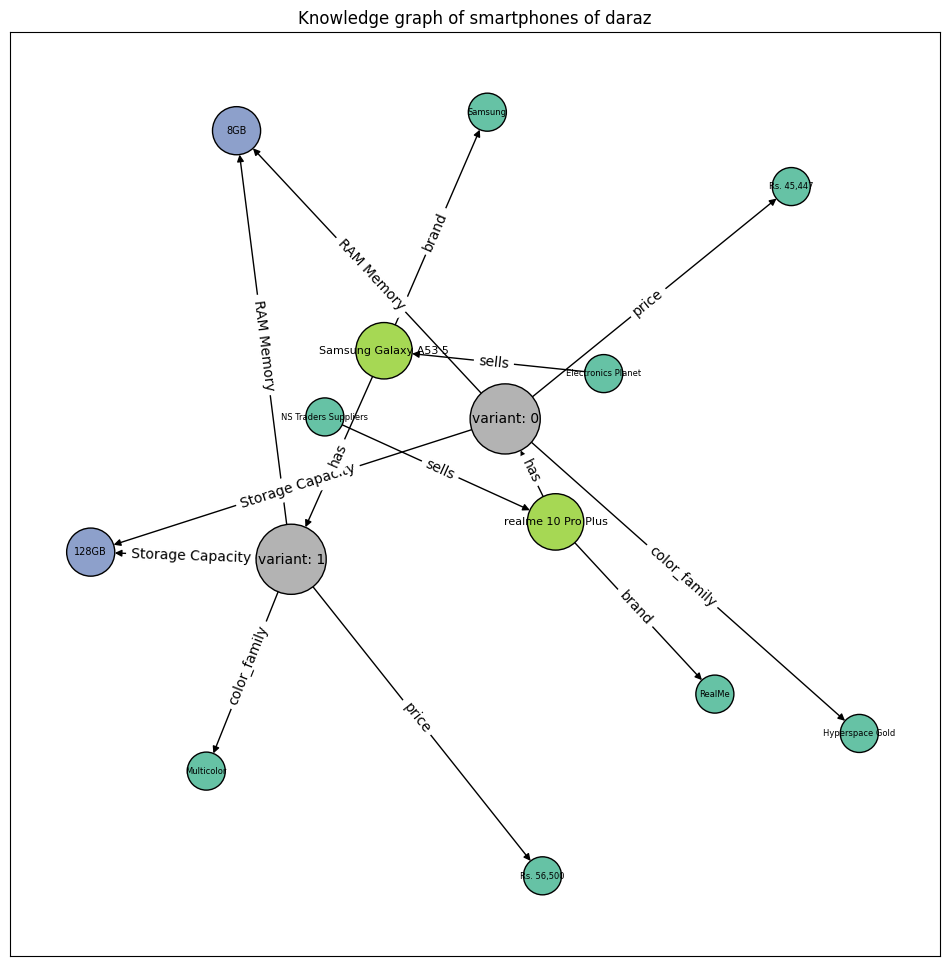

In [21]:
display_graph(KG)

We have successfully created knowledge graph from web scraped data. Now, it's time to do some queries.
Since, networkx doesnot supports querying language, we have to build a function from scratch.

# Queries on Knowledge graph

In [22]:
KG_lg=nx.from_pandas_edgelist(df_tuples,
                            source='source',target='target',edge_attr='edge',
                            create_using=nx.MultiDiGraph())

## Building a querying function 
- Extract all the product's name that have based on RAM, storage capacity and brand name.

In [23]:
def find_nodes(edge=None, target=None, G=None, candidates=[]):
    '''
        helps to find those source nodes 
        that are associated with the given edge, target node and candidates nodes 
        
        args:
            edge: string
            target: string
            G: networkx graph object
            candidates: list of string; candidates node are those src node in which we are interesed
        returns:
            result: list of src that matched the given condition
    '''
    result = []
    for src, tgt, edge_prop in G.edges(data=True):
        # check if the src and tgt are connected with the given edge or not; if not ignore
        condition_edge = True if not edge else edge_prop['edge'].lower()==edge.lower()
        # check if the tgt is target node or not; if not ignore
        condition_target = True if not target else str(tgt).lower() == target.lower()
        # check if src node is a candidates node or not; if not ignore
        condition_candidate = True if not candidates else src.lower() in candidates
        
        if condition_edge and condition_target and condition_candidate:
            result.append(src.lower())
            
    return list(set(result))

In [24]:
def query(ram, storage, brand, KG):
    # find variants that have 6GB RAM
    variants = find_nodes(edge='RAM Memory', target=ram, G=KG)
    
    # find variants that also have 256GM storage capacity
    variants_1 = find_nodes(edge='Storage Capacity',
                            target=storage,
                            G=KG, candidates=variants)
    # search for product that have variants_1
    candidate_product = find_nodes(edge='has', candidates=variants_1, G=KG)
    
    #find product that have given brand name
    query_product = find_nodes(edge='brand', target=brand, G=KG, candidates=candidate_product)
    
    return query_product

In [25]:
query(ram='8GB' , storage='256GB', brand='Redmi', KG=KG_lg)

['redmi a1 plus',
 'redmi a1',
 'redmi 10',
 'redmi 12c',
 'redmi note 11 snapdr',
 'redmi note 12 pro 5g',
 'redmi note 12']

You might have notied that we can easily and efficiently get this result directly from dataframe. Keep in mind, we are working in a small dataset, while we have multiple table then graph processing is much more efficient than relational database processing.